# Imports and Utils

In [300]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
from linearmodels import PanelOLS, FirstDifferenceOLS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline

# Import Data

In [2]:
with open("data_pull/ids/wave1_ids.txt", "r") as internal_f:
    wave1_ids = [line.strip() for  line in internal_f.readlines()]

# Semantic Location Processing

In [20]:
phq_loc = "/data/tliu/all_ema_data/evening_phq8"

even_phq_df = pd.DataFrame()

for pid in wave1_ids:
    df = pd.read_pickle("{}/{}.df".format(phq_loc, pid))
    even_phq_df = even_phq_df.append(df, sort=True)

In [21]:
even_ema_loc = "/data/tliu/all_ema_data/evening_ema"

even_ema_df = pd.DataFrame()

for pid in wave1_ids:
    df = pd.read_pickle("{}/{}.df".format(even_ema_loc, pid))
    even_ema_df = even_ema_df.append(df, sort=True)


In [49]:
even_phq_df = format_time(even_phq_df)
even_ema_df = format_time(even_ema_df)


print(even_phq_df.shape)
print(even_ema_df.shape)

(1280, 132)
(7268, 139)


In [50]:
keep_cols = ['source', 'timestamp', 'timezone-offset', 'data_source', 'date']

def extract_locs(row, loc_attr, max_nbr):
    """extracts location information from each row"""
    loc_df = pd.DataFrame()
    for i in range(max_nbr):
        # check for lat/long
        lat = "place-latitude-{}".format(i)
        if not pd.isnull(row[lat]):
            # we have a valid row
            row_dict = {}
            # populate metadata
            for col in keep_cols:
                row_dict[col] = row[col]
            # populate location attributes
            for attr in loc_attr:
                attr_name = "{}-{}".format(attr, i) 
                if attr_name in row.index and not pd.isnull(row[attr_name]):
                    row_dict[attr] = row[attr_name]
                else:
                    row_dict[attr] = np.nan
            series = pd.Series(row_dict)
            #print(series)
            loc_df = loc_df.append(series, ignore_index=True)
    return loc_df    

In [51]:
cols = list(even_ema_df.columns[even_ema_df.columns.str.startswith('place')].values)
# remove trailing numbering
attributes = ['-'.join(col.split('-')[:-1]) for col in cols]
attributes = list(set(attributes))

In [52]:
nbrs = [int(col.split('-')[-1]) for col in cols]
max(nbrs)

13

In [53]:
attributes

['place-kind',
 'place-name',
 'place-with-others',
 'place-medical-type',
 'place-longitude',
 'place-other',
 'place-latitude',
 'place-home-other',
 'place-home-type']

In [55]:
%%time

semantic_locs = pd.DataFrame()
for i, row in even_ema_df.iterrows():
    df = extract_locs(row, attributes, 14)
    semantic_locs = semantic_locs.append(df)

CPU times: user 3min 13s, sys: 993 ms, total: 3min 14s
Wall time: 3min 14s


In [59]:
cols = list(even_phq_df.columns[even_phq_df.columns.str.startswith('place')].values)
nbrs = [int(col.split('-')[-1]) for col in cols]
max(nbrs)

12

In [60]:
%%time

semantic_phq_locs = pd.DataFrame()
for i, row in even_phq_df.iterrows():
    df = extract_locs(row, attributes, 13)
    semantic_phq_locs = semantic_phq_locs.append(df)

CPU times: user 26.1 s, sys: 6.94 ms, total: 26.2 s
Wall time: 26.1 s


In [62]:
semantic_locs.shape

(20919, 14)

In [65]:
semantic_locs.head()

,data_source,date,place-home-other,place-home-type,place-kind,place-latitude,place-longitude,place-medical-type,place-name,place-other,place-with-others,source,timestamp,timezone-offset
0,wave1,2019-07-31,,NaN,Work,41.696917536363635,-91.61501816363635,NaN,,,NaN,08343773,1.564554e+09,-18000.0
1,wave1,2019-07-31,,NaN,Home,41.750549219999996,-91.613768644,NaN,,,NaN,08343773,1.564554e+09,-18000.0
2,wave1,2019-07-31,,NaN,Other…,42.037710972000006,-91.65751631200001,NaN,Tax Act,This is a tax software company that was conduc...,NaN,08343773,1.564554e+09,-18000.0
3,wave1,2019-07-31,,NaN,Food and Drink,41.70016786,-91.60922634,NaN,Culver's,,alone,08343773,1.564554e+09,-18000.0
0,wave1,2019-07-31,,NaN,Home,41.750478669662925,-91.61372453370785,NaN,,,NaN,08343773,1.564628e+09,-18000.0


In [66]:
semantic_locs = semantic_locs.append(semantic_phq_locs)
semantic_locs = semantic_locs.sort_values(by=['source', 'date'])

In [119]:
semantic_locs.shape
semantic_locs['place-kind'].value_counts()

Home                                                       8859
Work                                                       5271
Food and Drink                                             2291
Another Person's Home                                      1837
I Was Not There                                            1815
Shopping                                                   1688
Other…                                                     1241
Errand                                                      962
Medical/Dentist/Mental Health                               945
Education                                                   713
Entertainment                                               679
Gym/Exercise                                                673
Commute/Travel (Airport, Bus Stop, Train Station, Etc.)     644
Place of Worship (Church, Temple, Etc.)                     307
Beauty/Grooming                                             141
Childcare                               

In [80]:
semantic_locs['pid'] = semantic_locs['source']

In [81]:
semantic_locs.to_pickle("ls_data/slocs.df")

## Semantic Location labelling

In [110]:
from geopy.distance import distance

def tag_semantic_locs(pid, sloc_df, file_loc, cluster_rad=500):
    """
    Tags each location sensor reading with a semantic label, if applicable.
    
    We only use labelled locations from the same week of data collection, or earlier.
    
    Args:
        pid (str): participant id
        sloc_df (df): the semantic location DataFrame loaded from file
        file_loc (str): the file location for the location df
        cluster_rad (int): the maximum cluster radius
        
    Returns:
        "raw" DataFrame with long/lat labelled
    """
    print(pid)
    loc_df = pd.read_pickle("{}/{}.df".format(file_loc, pid))
    if loc_df.shape[0] < 1:
        return 
    loc_df = format_time(loc_df)
    sloc_pid = sloc_df.loc[sloc_df['pid'] == pid]
    sloc_pid = sloc_pid[sloc_pid['date'] <= max(loc_df['date'])]
    places = []

    for i, loc_row in loc_df.iterrows():

        dist = cluster_rad + 5
        for j, sloc_row in sloc_pid.iterrows():
            dist = distance((loc_row['latitude'], loc_row['longitude']), (sloc_row['place-latitude'], sloc_row['place-longitude'])).m
            if dist < cluster_rad:
                break
                
        if dist < cluster_rad:
            places.append(sloc_row['place-kind'])
        else:
            places.append(np.nan)

    loc_df['place-kind'] = places
    
    return loc_df[['pid', 'date', 'time', 'latitude', 'longitude', 'place-kind']]
    
    

In [89]:
max(semantic_locs['date'])

Timestamp('2019-11-19 00:00:00')

In [ ]:
pd.read_pickle

In [95]:
%%time
fus_loc = "/data/tliu/wk4_ls_data/pdk-location"
test = tag_semantic_locs(wave1_ids[0], semantic_locs, fus_loc)

08343773
Index(['accuracy', 'altitude', 'bearing', 'encrypted_transmission',
       'generator', 'generator-id', 'latitude', 'location_timestamp',
       'longitude', 'observed', 'provider', 'source', 'speed', 'timestamp',
       'timezone', 'timezone-offset', 'pid', 'data_source', 'adj_ts', 'time',
       'date', 'hour'],
      dtype='object')
CPU times: user 10.4 s, sys: 25.8 ms, total: 10.4 s
Wall time: 10.4 s


In [114]:
def build_sloc(pid, in_loc, out_loc):
    """Builds and dumps raw semantic location df"""
    
    df = tag_semantic_locs(pid, semantic_locs, in_loc)
    pd.to_pickle(df, "{}/{}.df".format(out_loc, pid))

In [115]:
wks = [4, 7,10,13,16]
fus_loc = "/data/tliu/wk{}_ls_data/pdk-location"
sem_loc = "/data/tliu/wk{}_ls_data/semantic-location"

f_args = []
for wk in wks:
    for pid in wave1_ids:
        f_args.append((pid, fus_loc.format(wk), sem_loc.format(wk)))
        

In [116]:
%%time

import multiprocessing

with multiprocessing.Pool(12) as pool:
    results = pool.starmap(build_sloc, f_args)

21594071
01254121
75282136
11770862
08343773
71219000
57473014
91788916
28949890
58081753
01225297
74626135
20206315
03384972
65381988
73518938
19663467
47688944
18583649
05261598
33250639
39106805
56184073
27761141
34262165
00746649
32573840
50550619
90229239
56723660
72685265
93519386
07854544
61131074
89434074
08007167
99050875
31456993
80657933
38646138
53236058
80504454
17328943
27099517
29149362
01495950
14113160
80700486
78681731
69335292
35493515
18156803
83062037
89346491
58780031
02144163
55979795
79819446
09489685
79510141
72038219
59764431
48625414
70483015
03327555
26080346
58740880
59654069
28939704
62860600
65143770
87400142
86283726
64292248
71043609
74575289
17294720
13567195
27762780
42258080
45517860
99338619
14753485
76854891
53435128
22086591
51456954
80206225
95556839
06638392
73916801
79316475
38890840
03233601
69452375
39548248
26957252
28244292
46002724
55542659
14549710
50765631
27330785
56910929
87929316
12807049
86756971
77842251
62375942
52982527
81049144
7

38890840
55463070
62463869
02144163
55979795
29878406
00746649
68756107
89346491
32309079
80504454
44933937
59764431
91788916
20206315
09611865
08007167
76366191
58740880
53236058
74626135
18740846
80700486
35493515
79819446
58081753
14113160
83062037
22498610
77842251
11927637
74739196
99338619
47688944
93519386
79510141
07854544
29149362
23066392
64292248
17294720
39106805
56184073
27762780
09269616
42871706
43292038
11436422
26957252
22086591
48625414
53808826
80206225
73916801
71043609
03233601
13567195
23388083
27099517
89346491
71676393
75348018
45517860
44293762
44667026
28949890
70483015
03327555
61762096
27330785
50765631
14549710
28021601
62375942
52982527
81049144
59764431
09489685
95556839
06638392
79819446
87929316
28244292
64142475
46002724
21894119
90763832
42215399
58740880
45433155
22656406
59222410
86283726
08103884
44655272
52064875
64292248
93606382
32718334
50707558
36969413
67900112
21594071
76432041
48367404
47363974
91048552
35576469
28458341
22086591
55915099
9

## Semantic Location Processing

In [131]:
sloc_map = {
    "Food and Drink" : "food",
    "Home" : "home",
    "Work" : "work",
    "Gym/Exercise" : "exercise",
    "Another Person's Home" : "anothers_home",
    "Place of Worship" : "religion",
    "Commute/Travel" : "travel",
    "Shopping" : "shopping",
    "Errand" : "errand",
    "Medical/Dentist/Mental Health" : "health",
    "Education" : "education",
    "Entertainment" : "entertainment",
    "Other..." : "other",
    np.nan : "n/a"
}

In [145]:
def process_transition_hr(time, sloc_group):
    #sloc_pid = sloc_all_df.loc[sloc_all_df['pid'] == test_id]
    num_transitions = 0
    transition_dict = {}
    transition_dict['hr'] = time
    
    for sloc in sloc_map.values():
        transition_dict[sloc + '_dur'] = 0

    for sloc_i in sloc_map.values():
        for sloc_j in sloc_map.values():
            if sloc_i is not sloc_j:
                transition_dict[sloc_i + '_' + sloc_j] = 0
    
    cur_loc = sloc_group.iloc[0]['place-kind-fmt']
    cur_time = sloc_group.iloc[0]['time']
    for i, row in sloc_group.iterrows():
        next_loc = row['place-kind-fmt']
        next_time = row['time']
        if next_loc is not cur_loc:
            num_transitions += 1
            transition_dict[cur_loc + '_dur'] += (next_time - cur_time).total_seconds()
            transition_dict[cur_loc + '_' + next_loc] += 1
            cur_loc = next_loc
            cur_time = next_time
    
    # at the bottom of the hour
    transition_dict[cur_loc + '_dur'] += ((time + pd.Timedelta(1, unit='h')) - cur_time).total_seconds()
    
    transition_dict['tot_tansitions'] = num_transitions
    #print(transition_dict)
    return transition_dict


def build_sloc_hr(pid, loc):
    print(pid)
    sloc_hr = pd.DataFrame()
    sloc_pid = pd.read_pickle("{}/{}.df".format(loc, pid))
    if sloc_pid is None:
        return
    if sloc_pid.shape[0] < 1:
        return
    
    sloc_pid['hour'] = sloc_pid['time'].dt.floor('H')
    sloc_pid['place-kind-fmt'] = sloc_pid['place-kind'].map(sloc_map)
    sloc_pid['place-kind-fmt'] = sloc_pid['place-kind-fmt'].fillna('other')

    for time, group in sloc_pid.groupby("hour"):
        sl = pd.DataFrame(process_transition_hr(time, group), index=[0])
        sloc_hr = sloc_hr.append(sl)

    sloc_hr = sloc_hr.set_index('hr')
    sloc_hr = sloc_hr.resample('1H').sum()
    sloc_hr = sloc_hr.reset_index()
    sloc_hr['pid'] = pid

    return sloc_hr

In [146]:
%%time

test = build_sloc_hr(wave1_ids[0], sem_loc.format(4))

08343773
CPU times: user 6.57 s, sys: 7.97 ms, total: 6.58 s
Wall time: 6.57 s


In [147]:
sensor_locs = [sem_loc]
wks = [4, 7, 10, 13, 16]

# load data
with open("data_pull/ids/wave1_ids.txt", "r") as internal_f:
    wave1_ids = [line.strip() for  line in internal_f.readlines()]

    
def process_sensor_data(pids, loc, out_loc, func, n_procs=4):
    """Wrapper function for processing sensor data.
    
    Args:
        pids (list): list of pids to process
        #wk (int): the week of data to process
        loc (str): the file location
        out_loc (str): the output file name and location
        func (function): the processing function to apply
        n_procs (int): the number of processes to spin up
    
    Returns:
        None, but writes to 
    """
    #loc = loc.format(wk)
    func_args = [(pid, loc) for pid in pids]
    with multiprocessing.Pool(n_procs) as pool:
        results = pool.starmap(func, func_args)
        
    df = pd.DataFrame()

    for res in results:
        df = df.append(res)
    
    df.to_pickle(out_loc)
        

sloc_str = "ls_data/wk{}/sloc_hr.df"

def process_all_data(pids, wks, n_procs=4):    
    for wk in wks:
        process_sensor_data(pids, sem_loc.format(wk), sloc_str.format(wk), build_sloc_hr, n_procs)

In [148]:
%%time

process_all_data(wave1_ids, wks, n_procs=12)

44667026
08343773
28244292
27099517
61762096
21594071
29878406
50550619
84469352
48367404
47363974
28949890
58780031
01254121
46002724
59222410
44655272
18583649
91788916
20206315
10285142
32718334
56912666
09489685
80504454
59654069
51419094
28939704
05261598
70483015
33250639
97678130
62860600
99050875
76854891
86283726
53435128
03327555
27761141
34262165
49001726
47688944
37168430
42258080
31456993
32573840
87485171
77842251
36969413
90496706
16777771
50765631
15565415
19410615
98250113
74575289
81729157
75348018
39106805
56184073
95556839
50730294
55313474
71219000
71676393
98621494
01495950
39548248
52982527
73518938
81049144
69452375
44909649
52581458
44293762
20706360
56596866
06638392
74739196
67900112
81720300
69335292
89434074
66873010
28540480
39725031
45433155
31477083
81968737
13250317
12807049
75282136
54841471
74371880
85752121
90638927
53808826
38646138
14753485
62463869
03939827
68744652
81558830
67597747
76432041
78911129
02970060
13051775
32309079
56723660
65143770
2

69335292
44293762
39548248
50730294
45433155
71219000
74739196
36969413
81729157
44909649
53808826
81720300
66873010
81968737
73518938
12807049
55313474
75282136
14753485
56596866
39725031
13250317
20706360
02970060
62463869
68744652
89434074
85752121
21894119
74371880
56723660
38646138
45761494
02817507
52581458
32309079
51456954
90638927
58093242
67597747
22498610
43589028
13051775
23066392
52064875
46484562
65143770
78681731
76432041
28540480
79316475
30501084
81558830
93606382
78911129
19674187
72038219
38588231
74589634
75696701
79439002
53097921
84902402
70035688
99127649
38890840
93627939
55542659
54841471
11770862
83085276
24936642
54461187
03384972
26080346
03939827
17328943
39561926
42871706
70027963
50939076
12616311
43292038
11436422
31574721
78352234
56910929
19663467
41606321
57473014
18156803
75437581
87400142
83062037
23388083
40932643
07974290
87929316
29384065
81249330
90229239
36795256
02144163
55979795
72685265
42215399
74805749
71189891
01225297
61131074
80657933
1

In [149]:
test_sloc = pd.read_pickle("ls_data/wk4/sloc_hr.df")


,hr,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,errand_dur,...,n/a_religion,n/a_travel,n/a_shopping,n/a_errand,n/a_health,n/a_education,n/a_entertainment,n/a_other,tot_tansitions,pid
0,2019-08-13 00:00:00,0.0,0.0,1405.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,1,3,08343773
1,2019-08-13 01:00:00,0.0,2380.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,08343773
2,2019-08-13 02:00:00,0.0,429.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,08343773
3,2019-08-13 03:00:00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,08343773
4,2019-08-13 04:00:00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,08343773


In [157]:
dur_cols = list(test_sloc.columns[test_sloc.columns.str.contains("dur")].values)
dur_cols = ['pid', 'hr'] + dur_cols
sloc_dur_df = test_sloc[dur_cols]
sloc_dur_df['date'] = sloc_dur_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [158]:
mean_dur_df = sloc_dur_df.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_df = mean_dur_df.groupby('pid', as_index=False).mean()

In [164]:
mean_dur_df.head()

,pid,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,errand_dur,health_dur,education_dur,entertainment_dur,other_dur,n/a_dur
0,00746649,0.000000,39645.150000,4422.250000,1123.250000,915.900000,0,0,735.650000,961.450000,0.000000,974.3,0.000000,998.000000,11801.050000
1,01225297,0.000000,40593.375000,587.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,533.250000
2,01254121,699.727273,38712.227273,1438.318182,0.000000,0.000000,0,0,544.954545,56.272727,0.000000,0.0,0.000000,1460.909091,21160.363636
3,01495950,0.000000,33541.523810,10302.095238,323.047619,2050.761905,0,0,0.000000,0.000000,223.142857,0.0,0.000000,790.285714,1504.571429
4,01766910,85.285714,11801.333333,4182.285714,0.000000,42870.666667,0,0,529.285714,79.761905,0.000000,0.0,255.857143,1799.142857,10833.380952


In [160]:
mean_dur_df.describe()

,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,shopping_dur,errand_dur,health_dur,education_dur,entertainment_dur,other_dur,n/a_dur
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.0,274.0,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,429.163520,34604.473353,6833.807380,187.759910,1830.234157,0.0,0.0,312.461943,635.733736,235.533689,185.157620,323.438611,2334.165727,7981.314834
std,829.258803,19939.306391,8461.871246,753.564317,5078.850460,0.0,0.0,612.960909,4685.492840,597.704867,1308.560307,3412.655714,7735.550094,9408.796546
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19473.987500,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2888.924405
50%,60.600000,36961.325163,3919.392857,0.000000,0.000000,0.0,0.0,16.142857,0.000000,0.000000,0.000000,0.000000,198.850000,5412.404762
75%,529.651786,50354.820833,12821.187500,0.000000,913.300000,0.0,0.0,386.583333,94.940476,166.857143,0.000000,0.000000,1359.047619,9703.845238
max,5026.850000,77814.000000,66598.523810,9568.571429,42870.666667,0.0,0.0,5636.761905,60523.380952,4805.904762,20064.428571,56252.900000,63807.761905,69751.750000


# Baseline Clustering

##  Load Data

In [165]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

### PSQI notes

- pna: 999
- habitual sleep efficiency not calculated correctly

In [182]:
state_df.columns.values

array(['pid', 'redcap_event_name', 'gad_start', 'gad01', 'gad02', 'gad03',
       'gad04', 'gad05', 'gad06', 'gad07', 'gad08', 'txhx_start_fu',
       'psytxhx_psychother_3wk', 'psytxhx_curr_meds_fu', 'shaps_start',
       'shaps_01', 'shaps_02', 'shaps_03', 'shaps_04', 'shaps_05',
       'shaps_06', 'shaps_07', 'shaps_08', 'shaps_09', 'shaps_10',
       'shaps_11', 'shaps_12', 'shaps_13', 'shaps_14', 'psqi_start',
       'psqi_01', 'psqi_02', 'psqi_03', 'psqi_04', 'psqi_05a', 'psqi_05b',
       'psqi_05c', 'psqi_05d', 'psqi_05e', 'psqi_05f', 'psqi_05g',
       'psqi_05h', 'psqi_05i', 'psqi_05j', 'psqi_05j_1', 'psqi_05j_2',
       'psqi_06', 'psqi_07', 'psqi_08', 'psqi_09', 'spin_start',
       'spin_01', 'spin_02', 'spin_03', 'spin_04', 'spin_05', 'spin_06',
       'spin_07', 'spin_08', 'spin_09', 'spin_10', 'spin_11', 'spin_12',
       'spin_13', 'spin_14', 'spin_15', 'spin_16', 'spin_17'],
      dtype=object)

In [172]:
baseline_redcap_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

baseline_redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

baseline_redcap_df['pid'] = baseline_redcap_df['study_id'].map(baseline_redcap_dict)

def pad_pid(row):
    if len(row['pid']) < 8:
        return ('0' * (8-len(row['pid']))) + row['pid']
    else:
        return row['pid']

baseline_redcap_df['pid'] = baseline_redcap_df['pid'].astype(str)
baseline_redcap_df['pid'] = baseline_redcap_df.apply(pad_pid, axis=1)

In [242]:
phq_baseline = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']
phq_baseline = phq_baseline.drop(['phq_total_sc', 'phq_start', 'redcap_event_name'], axis=1)


In [250]:
baseline_df = state_df[state_df['redcap_event_name'] == 'week_0_arm_1']
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.startswith('psqi')]
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.endswith('start')]
baseline_df = baseline_df.loc[:, ~baseline_df.columns.str.contains('txhx')]
baseline_df = baseline_df.drop(['redcap_event_name'], axis=1)
psqi_comp_cols = ['psqi_durat', 'psqi_distb', 'psqi_laten', 'psqi_daydys', #'psqi_hse', 
                  'psqi_slpqual', 'psqi_meds']

#baseline_df = baseline_df.merge(baseline_redcap_df[['pid'] + psqi_comp_cols], on='pid', how='left')
baseline_df = baseline_df.merge(phq_baseline, on='pid', how='left')
baseline_df = baseline_df.replace(to_replace=[99,999], value=np.nan)

baseline_df.columns.values


array(['pid', 'gad01', 'gad02', 'gad03', 'gad04', 'gad05', 'gad06',
       'gad07', 'gad08', 'shaps_01', 'shaps_02', 'shaps_03', 'shaps_04',
       'shaps_05', 'shaps_06', 'shaps_07', 'shaps_08', 'shaps_09',
       'shaps_10', 'shaps_11', 'shaps_12', 'shaps_13', 'shaps_14',
       'spin_01', 'spin_02', 'spin_03', 'spin_04', 'spin_05', 'spin_06',
       'spin_07', 'spin_08', 'spin_09', 'spin_10', 'spin_11', 'spin_12',
       'spin_13', 'spin_14', 'spin_15', 'spin_16', 'spin_17', 'phq01_sc',
       'phq02_sc', 'phq03_sc', 'phq04_sc', 'phq05_sc', 'phq06_sc',
       'phq07_sc', 'phq08_sc', 'phq10_sc'], dtype=object)

## Clustering setup

In [251]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [252]:
np.random.seed(42)
pids = list(baseline_df['pid'])
np.random.shuffle(pids)
test_idx = int(len(pids) * .25)
test_pids = pids[:test_idx]
train_pids = pids[test_idx:]

#pickle.dump(test_pids, open("ls_data/test_pids.lst", "wb"), -1)
#pickle.dump(train_pids, open("ls_data/train_pids.lst", "wb"), -1)

In [277]:
train_baseline_df = baseline_df[baseline_df['pid'].isin(train_pids)]
train_baseline_df = train_baseline_df.set_index('pid')
train_baseline_df = train_baseline_df.loc[:, (train_baseline_df.columns.str.startswith('phq')) | 
                                             (train_baseline_df.columns.str.startswith('gad')) |
                                             (train_baseline_df.columns.str.startswith('spin'))]

train_baseline_df = train_baseline_df.fillna(train_baseline_df.mean())

In [278]:
scaler = StandardScaler()
transformed_X = scaler.fit_transform(train_baseline_df)

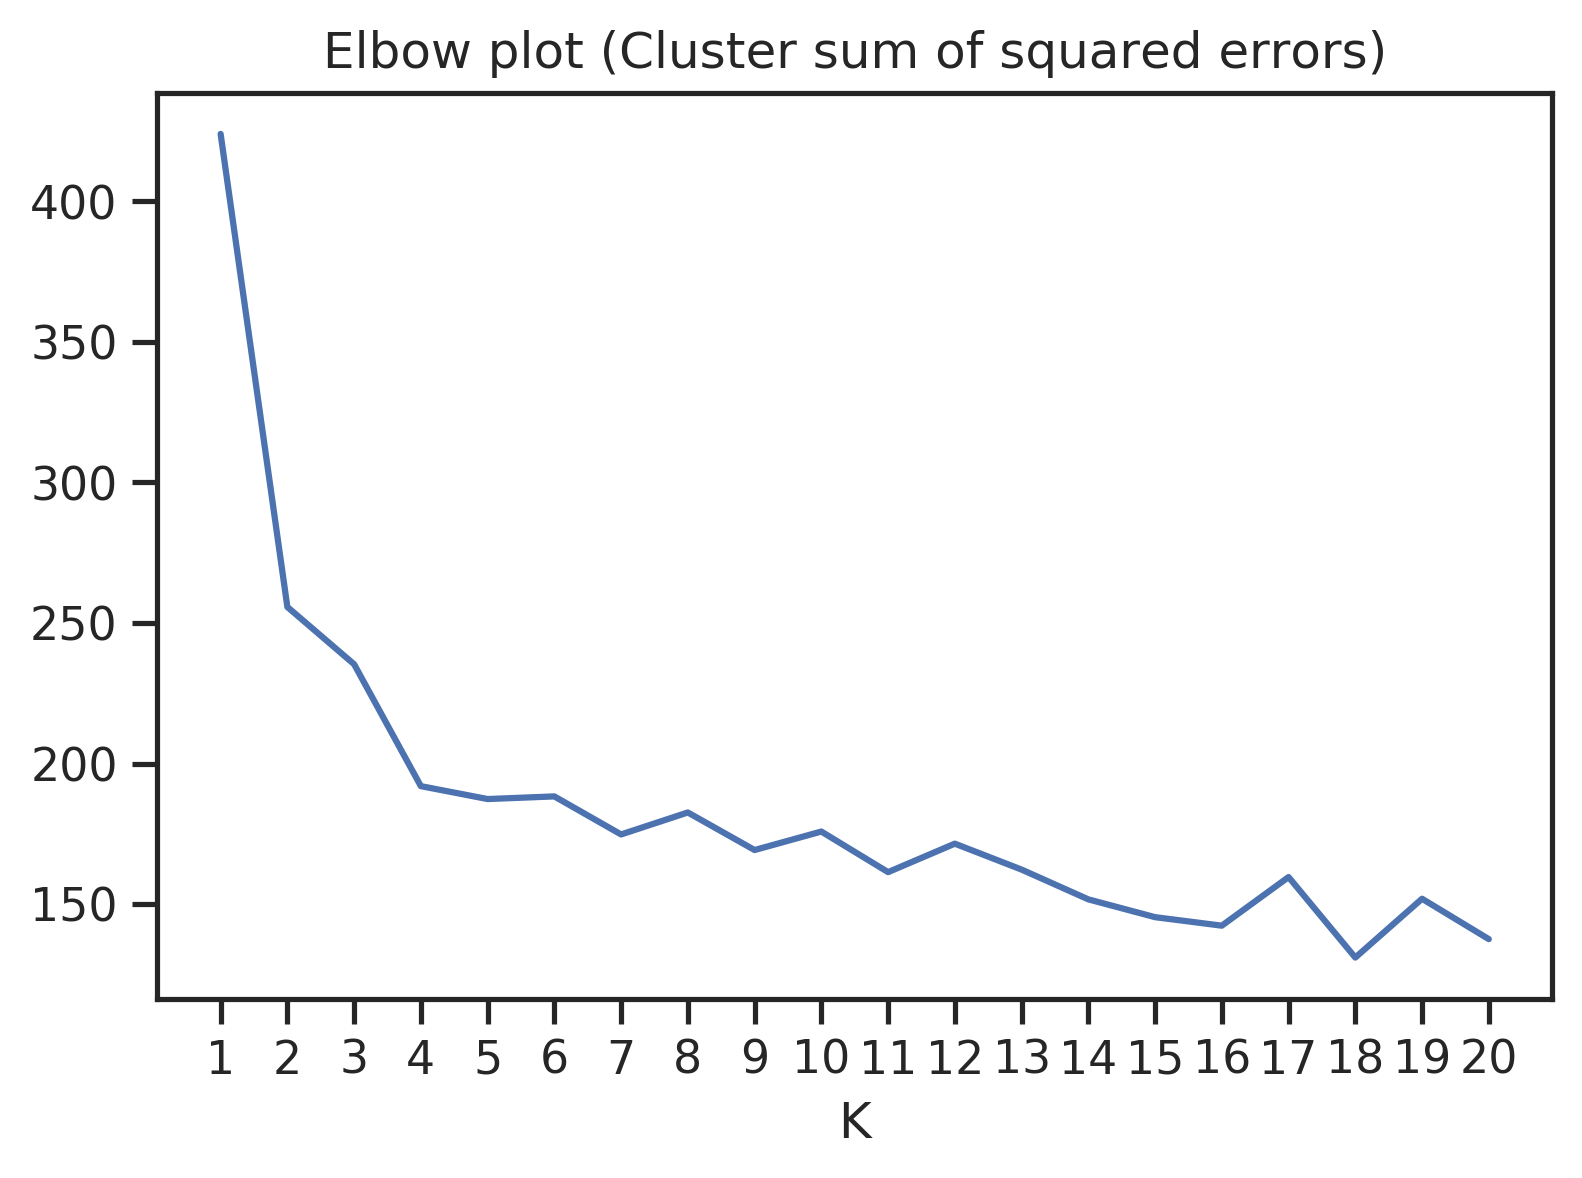

In [302]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init=25, max_iter=1000, random_state=43).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

max_k = 20

WSS = calculate_WSS(transformed_X, max_k)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.plot(np.arange(1,max_k+1), WSS)
plt.xticks(np.arange(1,max_k+1,1))
plt.title("Elbow plot (Cluster sum of squared errors)")
plt.xlabel("K")
plt.show()

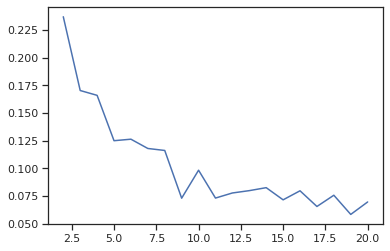

In [287]:
# silhoutte plot, TODO validate
# sil =  []
# Ks = np.arange(2,max_k+1)
# for k in Ks:
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(transformed_X)
#     labels = kmeans.labels_
#     sil.append(silhouette_score(transformed_X, labels, metric='euclidean'))
    

# plt.plot(Ks, sil)

## Final Clusters, K=4

In [309]:
kmeans = KMeans(n_clusters = 4, n_init=25, max_iter=1000, random_state=43).fit(transformed_X)
labels = kmeans.labels_
cluster_df = train_baseline_df.copy()
cluster_df['cluster'] = labels

['spin_02',
 'spin_07',
 'phq03_sc',
 'phq04_sc',
 'gad08',
 'phq05_sc',
 'gad06',
 'gad04',
 'gad01',
 'gad02',
 'gad03',
 'phq07_sc',
 'phq06_sc',
 'phq10_sc',
 'phq01_sc',
 'phq02_sc',
 'spin_13',
 'gad07',
 'gad05',
 'phq08_sc',
 'spin_17',
 'spin_01',
 'spin_16',
 'spin_11',
 'spin_03',
 'spin_04',
 'spin_10',
 'spin_08',
 'spin_09',
 'spin_05',
 'spin_12',
 'spin_15',
 'spin_06',
 'spin_14']

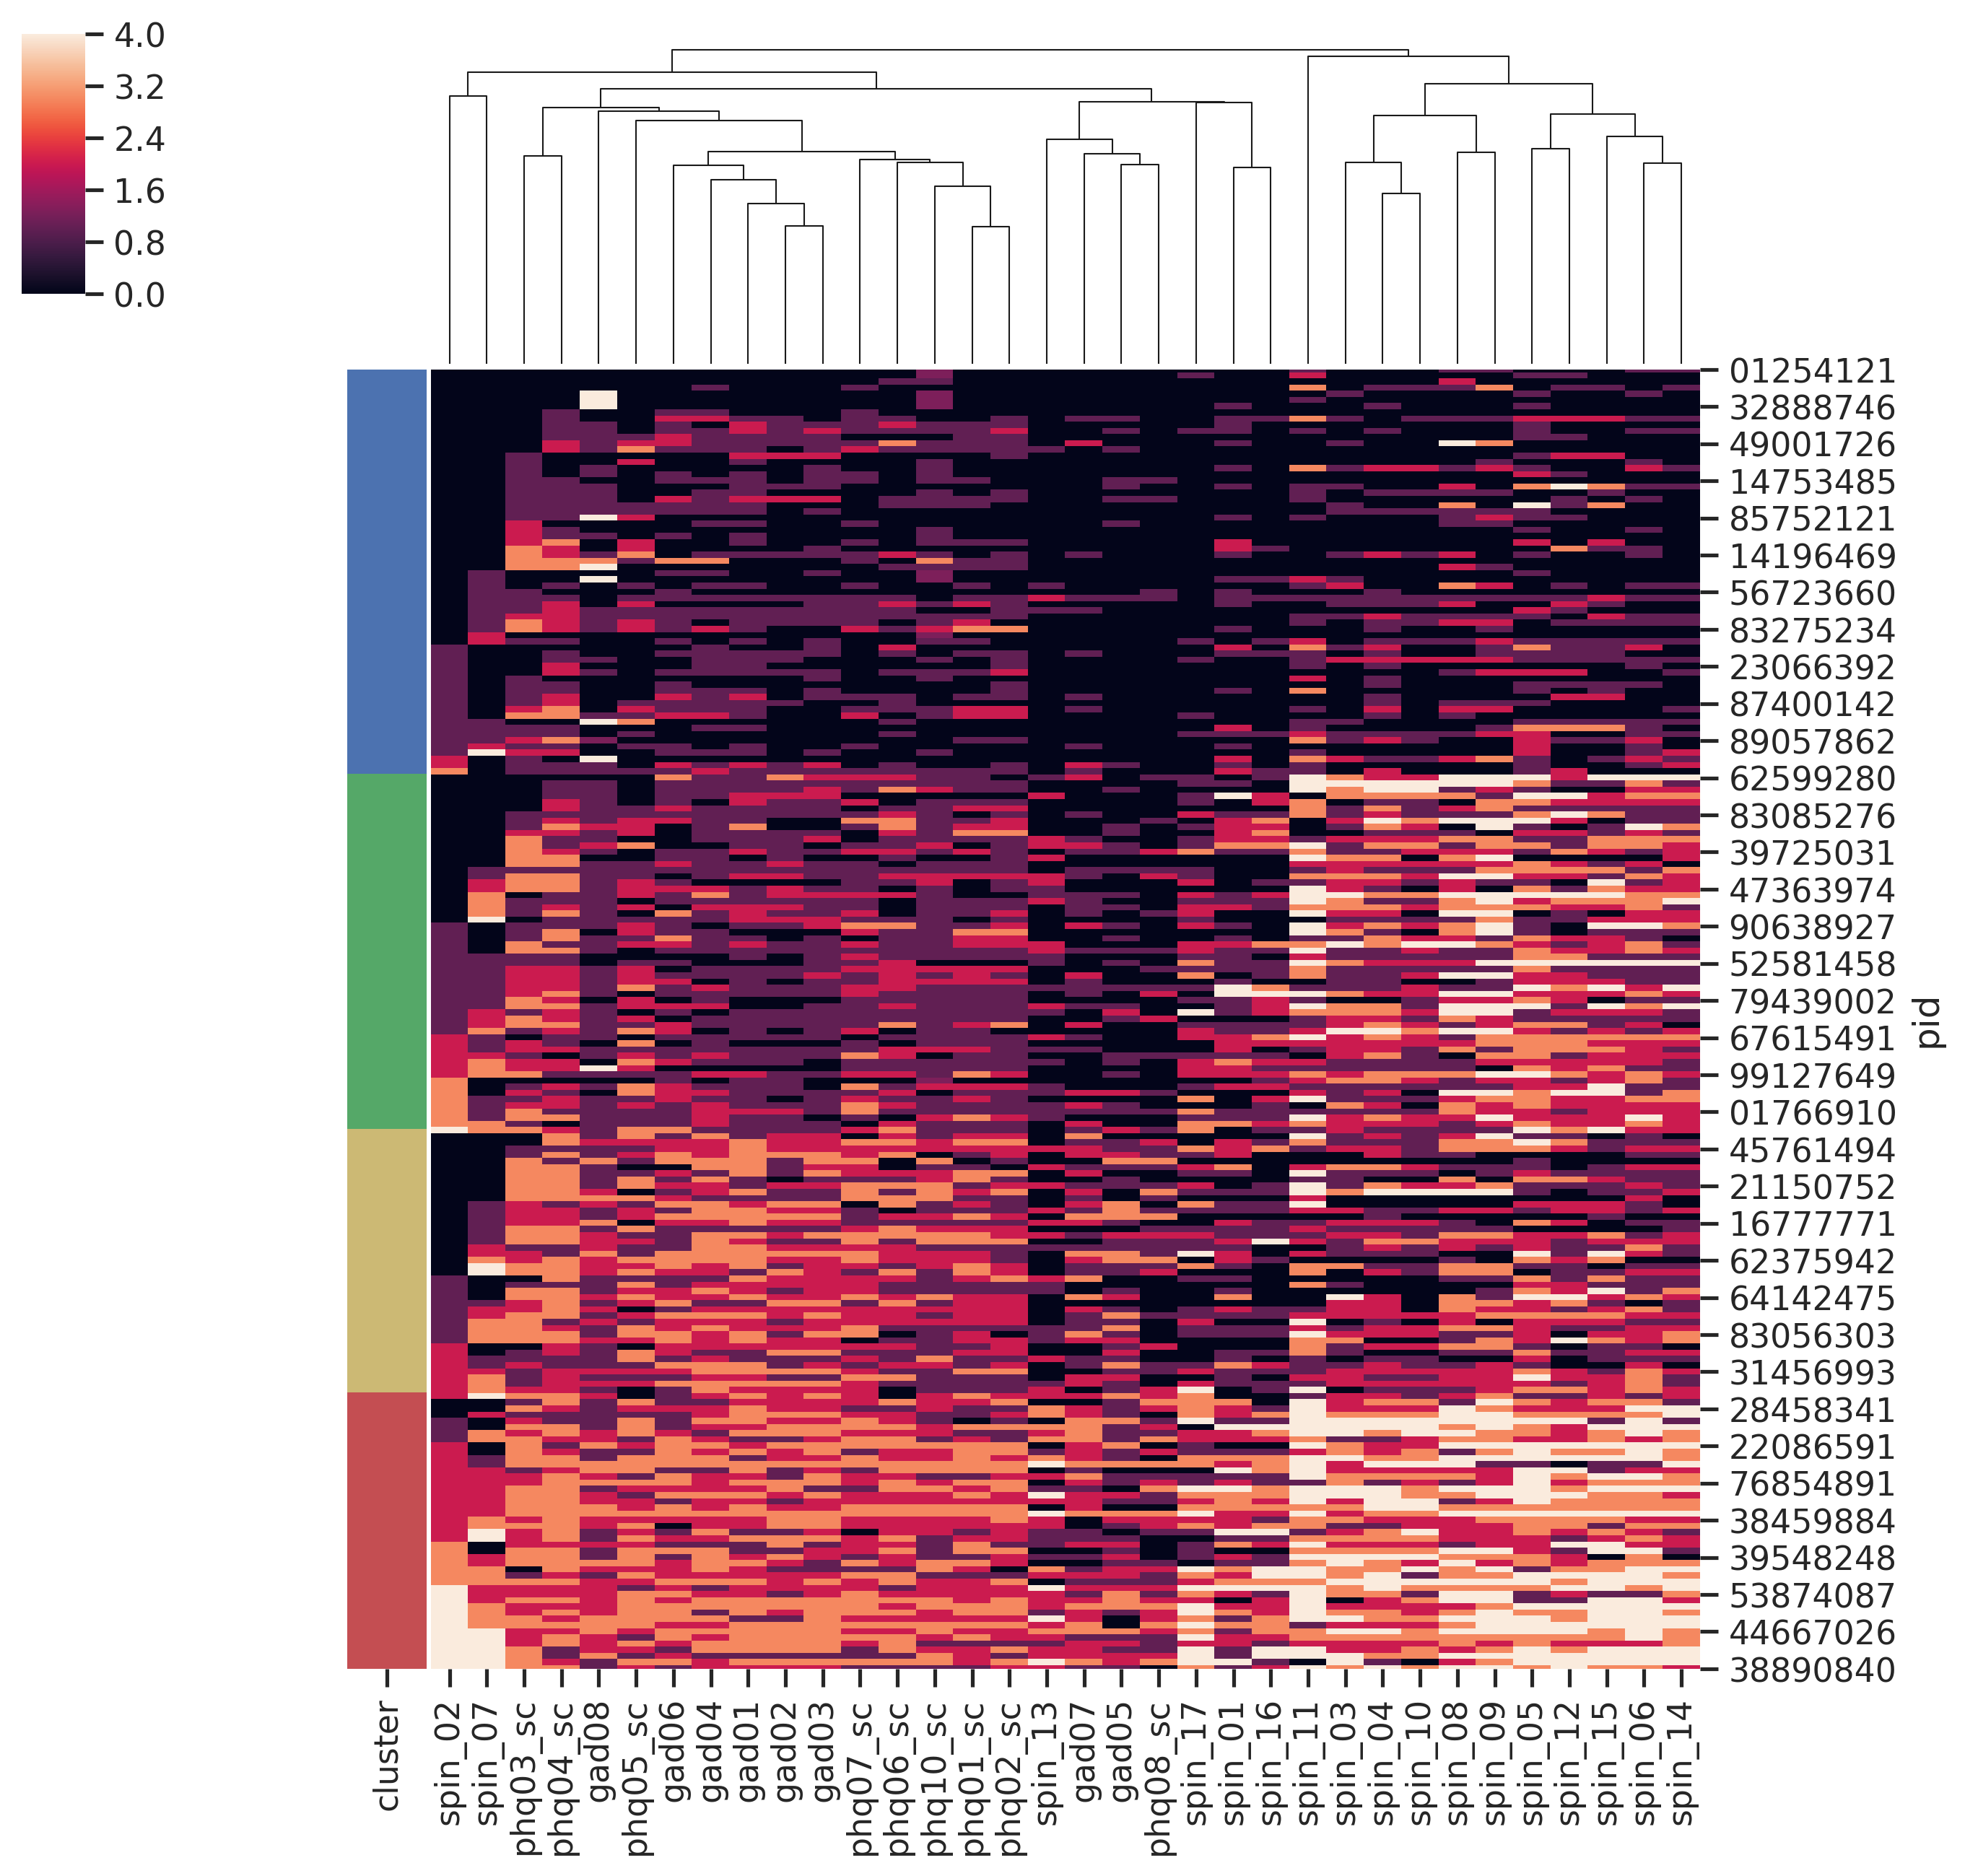

In [323]:
color_dict = {
    0: "b",
    1: "g",
    2: "y",
    3: "r"
}
cluster_df = cluster_df.sort_values(by=['cluster', 'spin_02', 'spin_07'])
row_colors = cluster_df['cluster'].map(color_dict)
clustergrid = sns.clustermap(cluster_df.drop(['cluster'], axis=1), 
               row_colors=row_colors, 
               #z_score=1,
               row_cluster=False)
reordered_col_ind = clustergrid.dendrogram_col.reordered_ind
reordered_col = [list(cluster_df.drop(['cluster'], axis=1))[i] for i in reordered_col_ind]
reordered_col

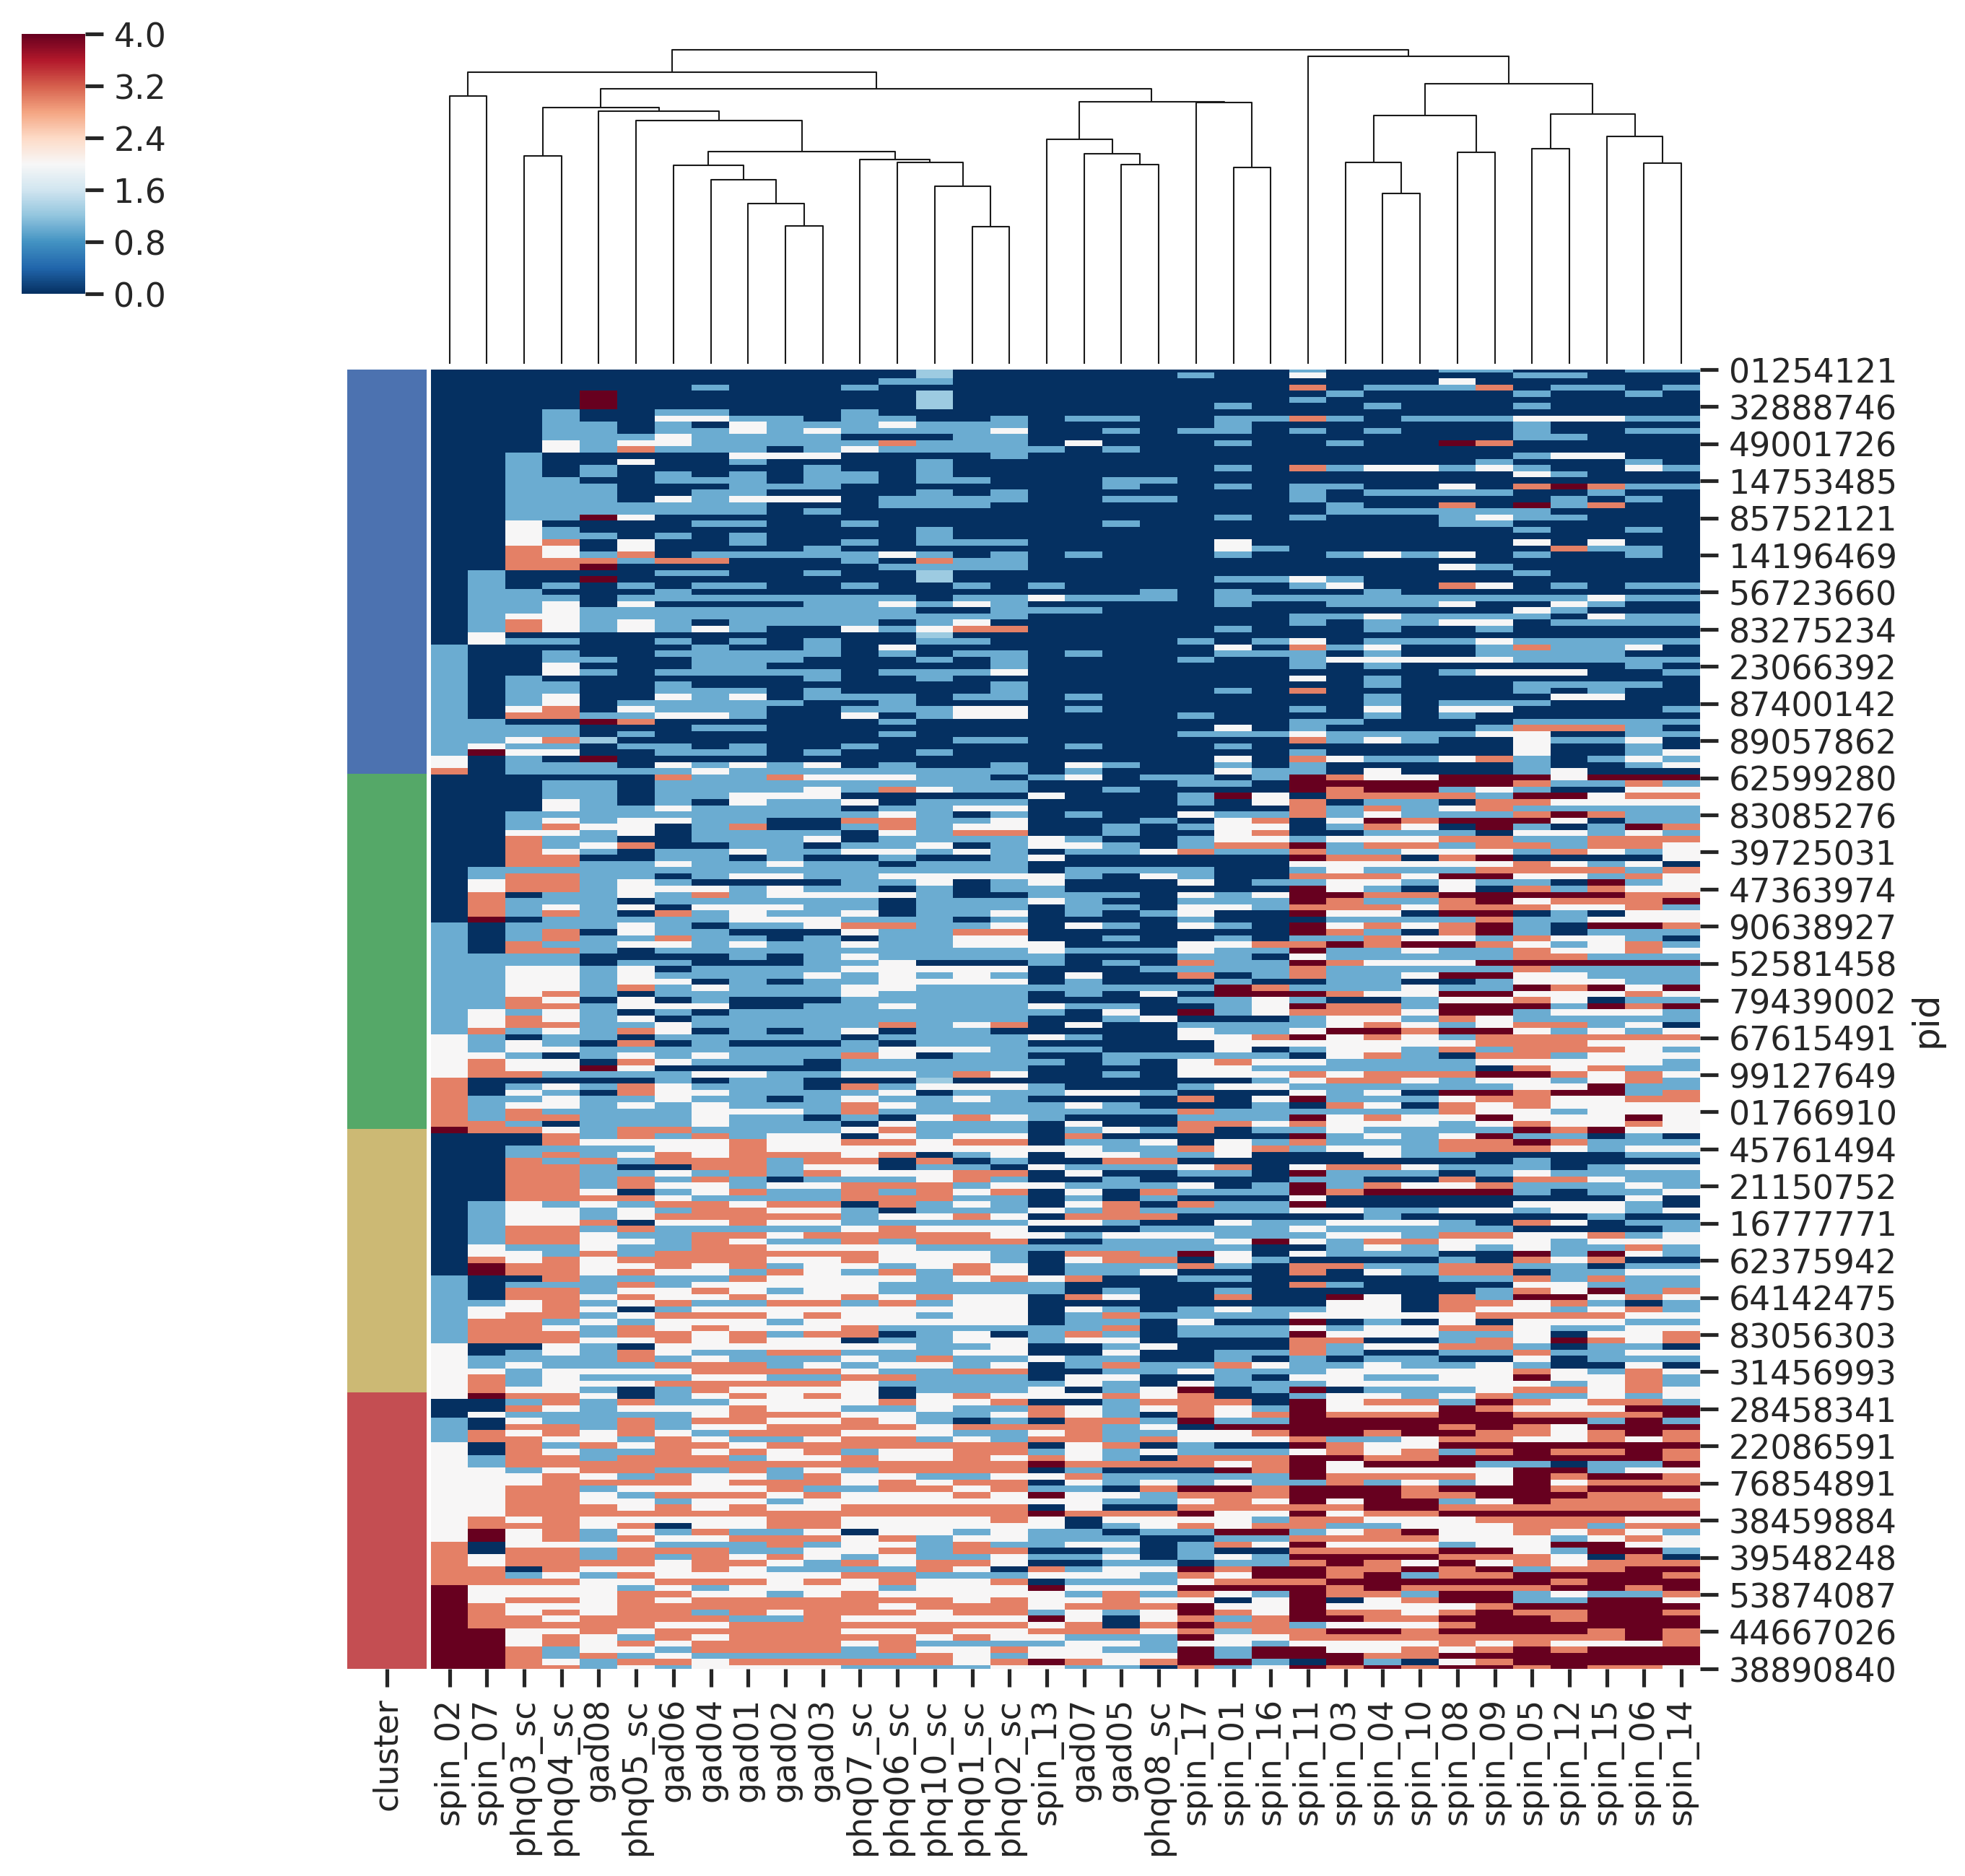

In [326]:
cluster_df = cluster_df.sort_values(by=['cluster'] + reordered_col)
row_colors = cluster_df['cluster'].map(color_dict)
clustergrid = sns.clustermap(cluster_df.drop(['cluster'], axis=1), 
               row_colors=row_colors, 
               row_cluster=False,
               cmap='RdBu_r')

In [328]:
cluster_df['spin_tot'] = cluster_df.loc[:, cluster_df.columns.str.startswith("spin")].sum(axis=1)
cluster_df['phq_tot'] = cluster_df.loc[:, cluster_df.columns.str.startswith("phq")].sum(axis=1)
cluster_df['gad_tot'] = cluster_df.loc[:, cluster_df.columns.str.startswith("gad")].sum(axis=1)

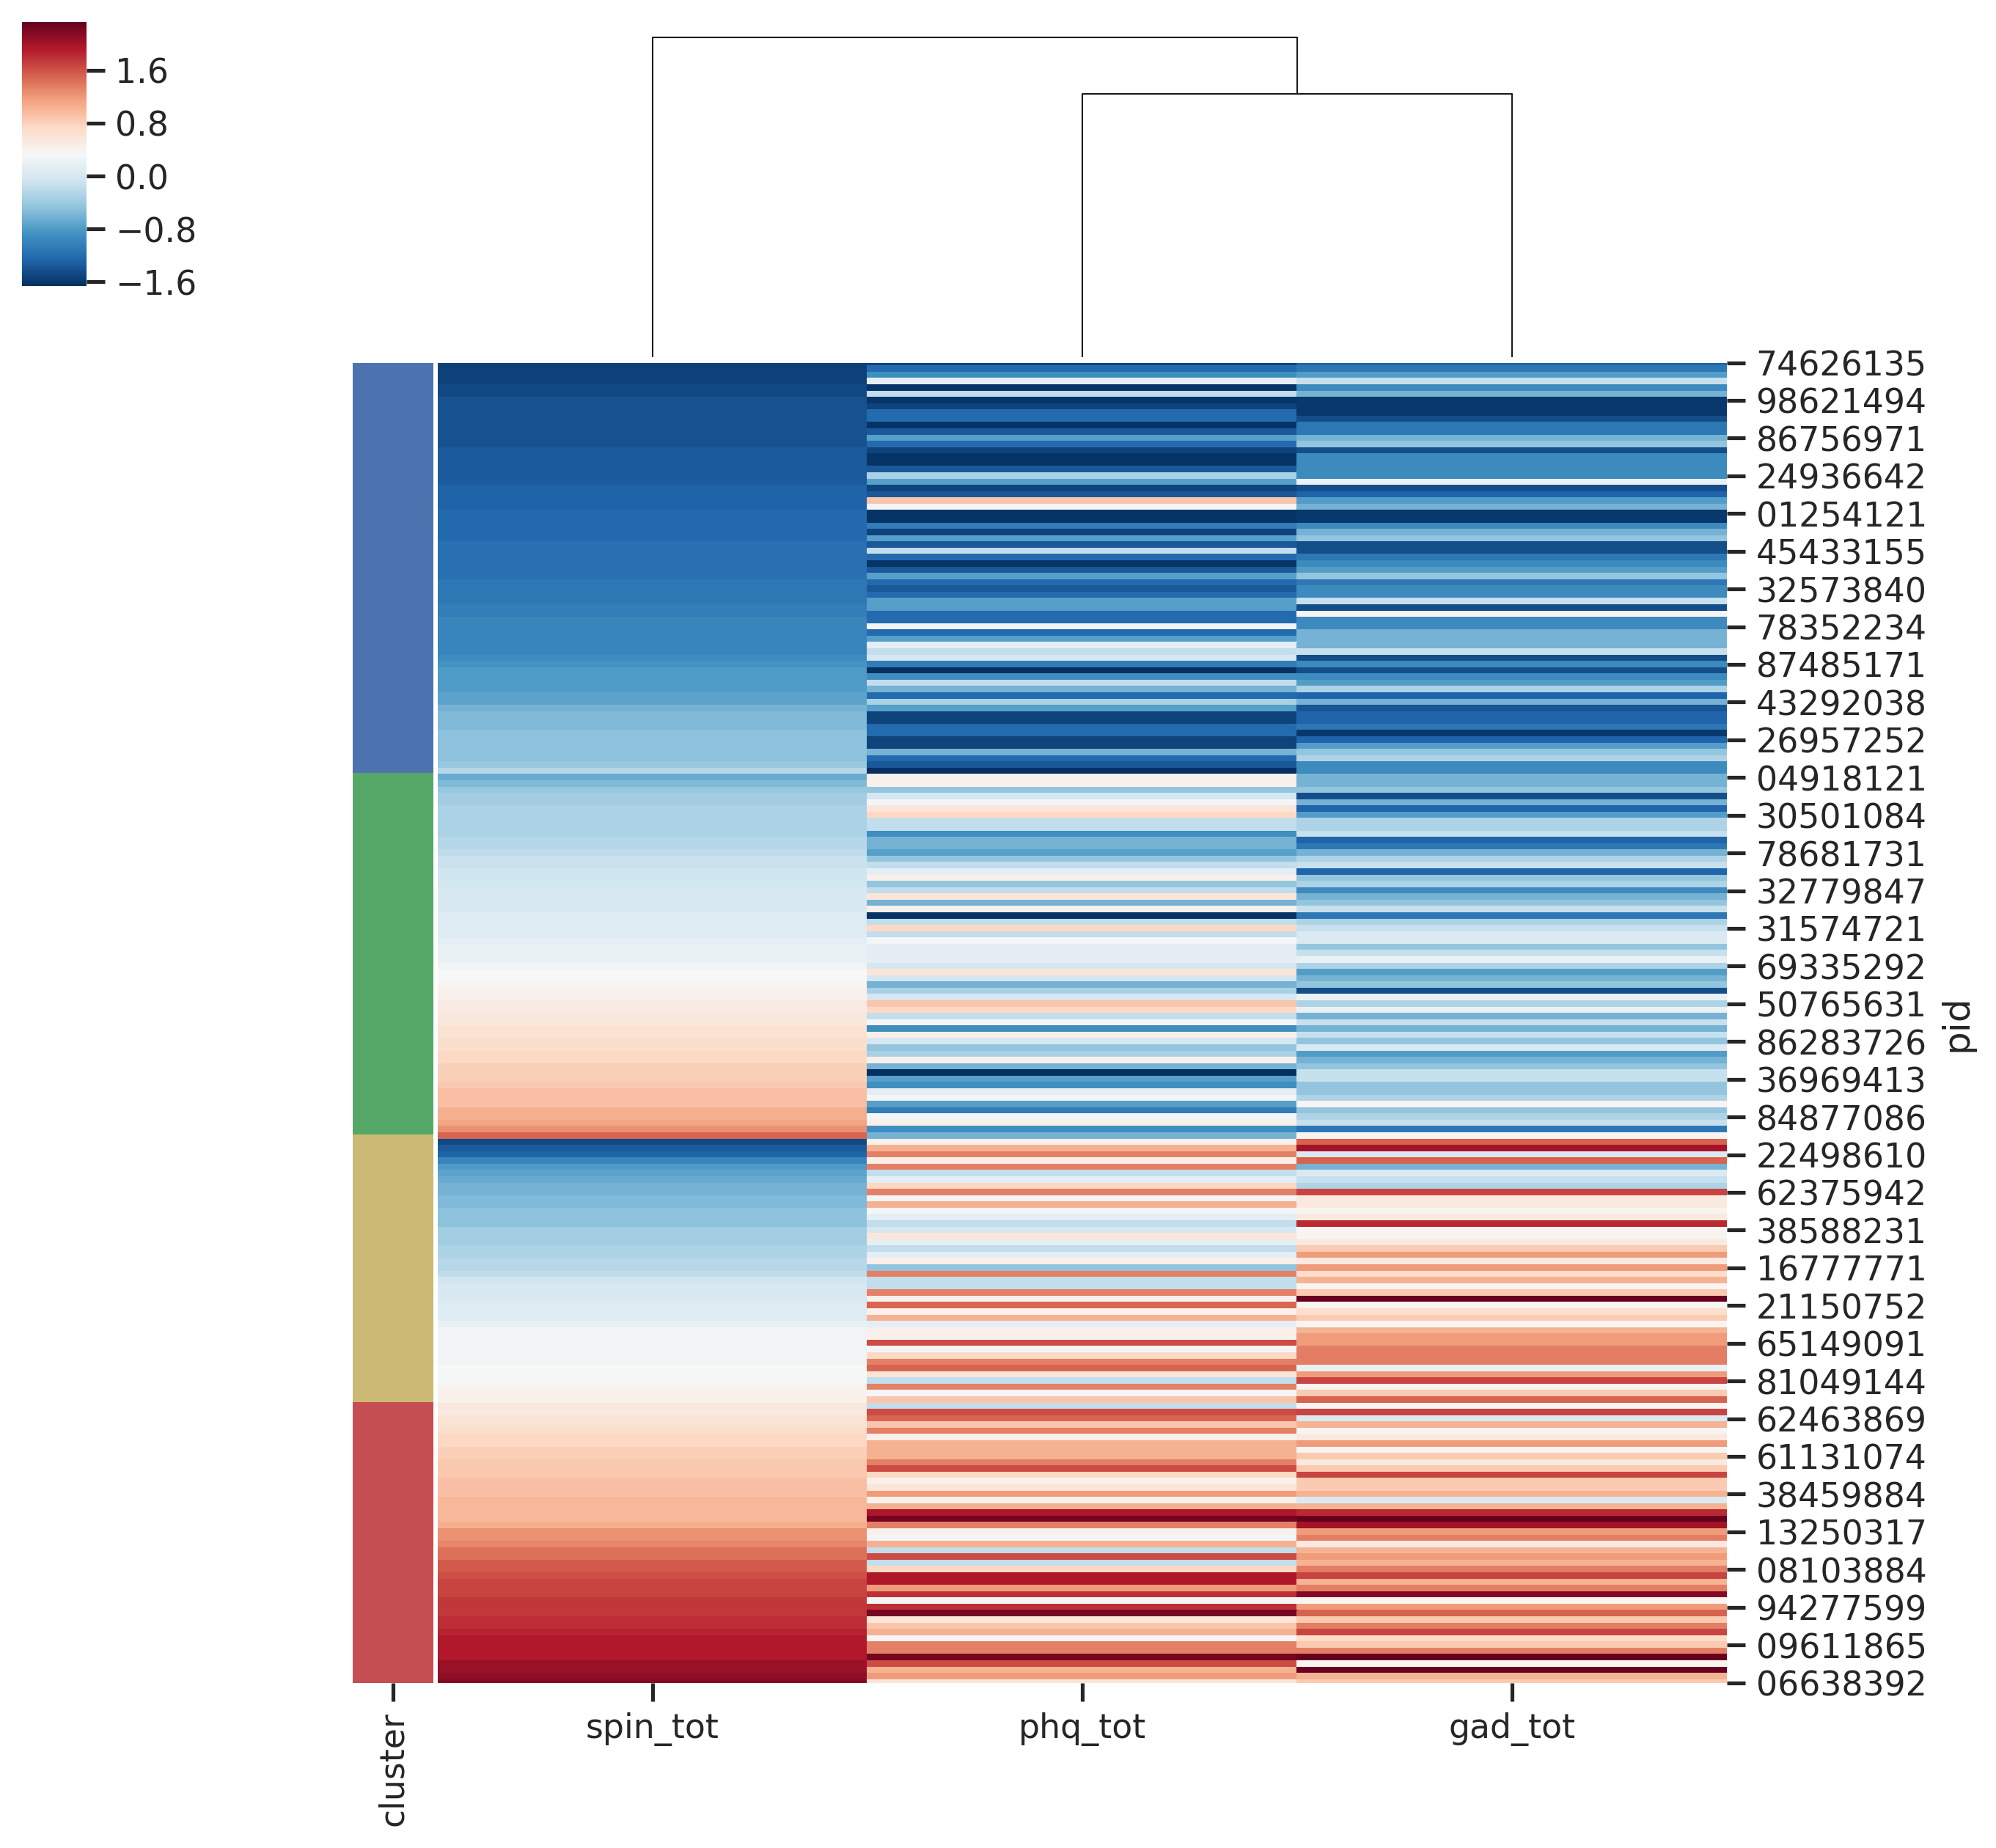

In [343]:
cluster_df = cluster_df.sort_values(by=['cluster', 'spin_tot', 'gad_tot', 'phq_tot'])

clustergrid = sns.clustermap(cluster_df[['spin_tot', 'phq_tot', 'gad_tot']], 
               row_colors=row_colors, 
               row_cluster=False,
               z_score=1,
               cmap='RdBu_r')

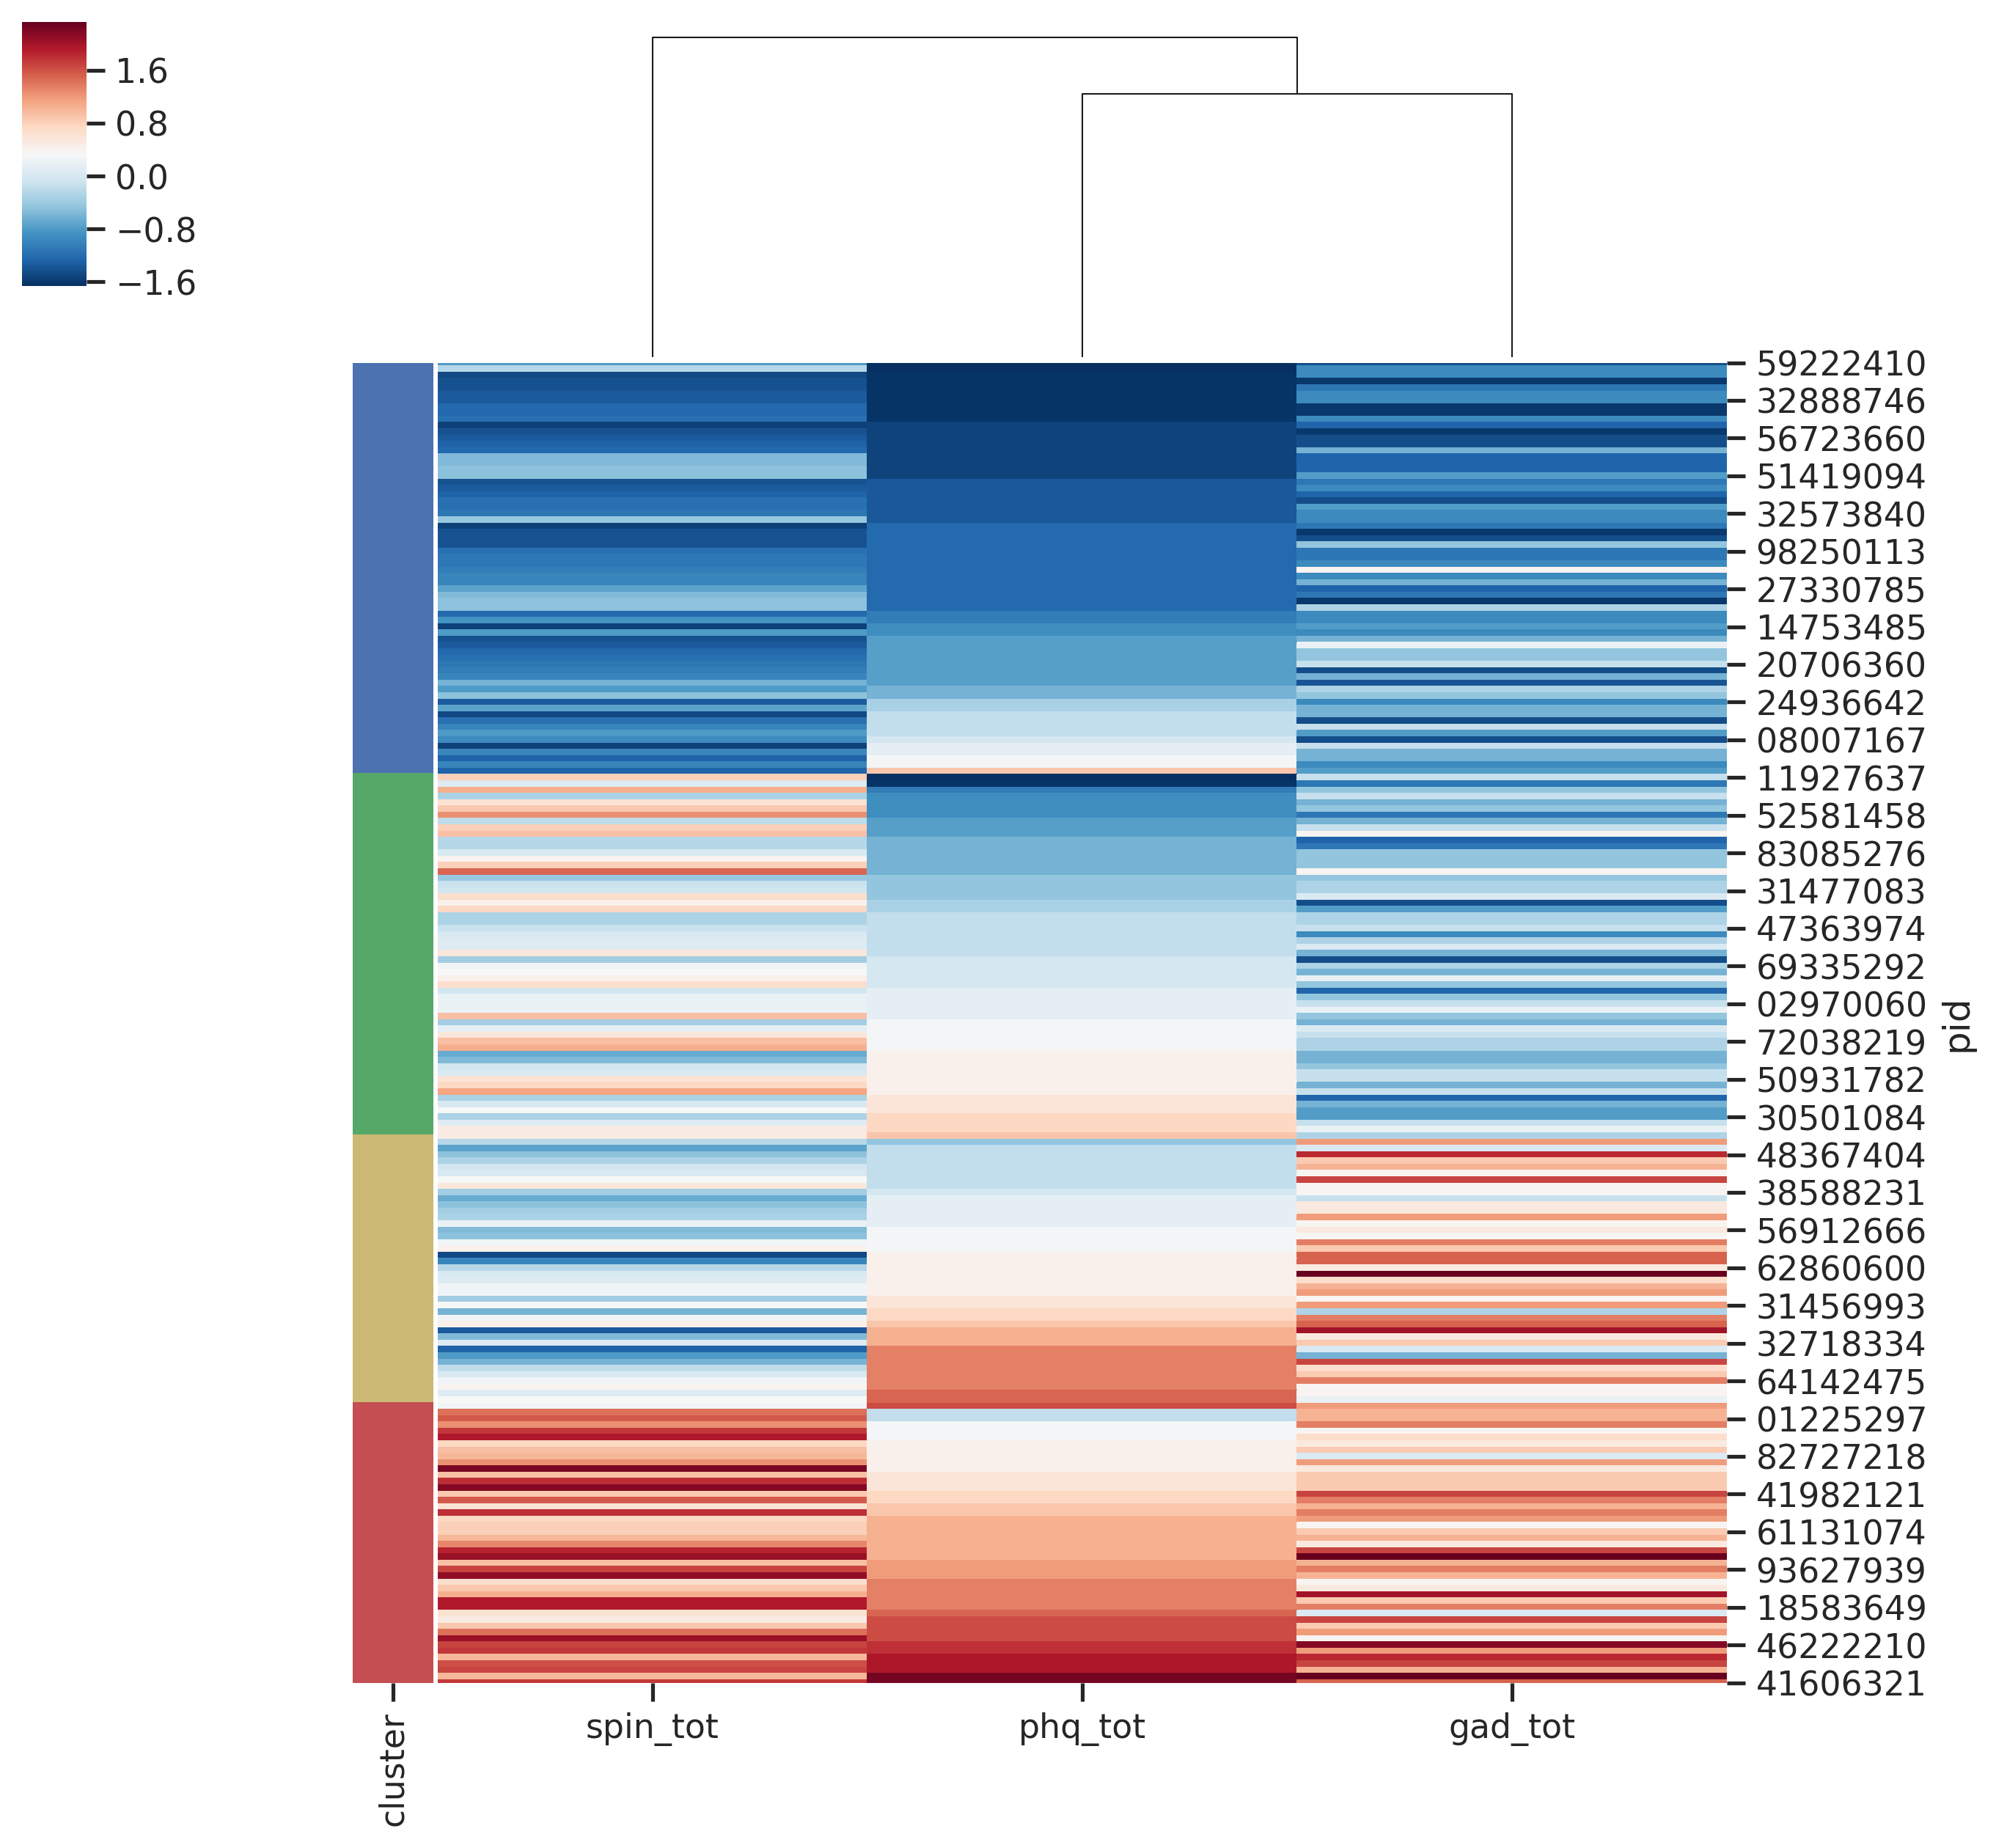

In [339]:
cluster_df = cluster_df.sort_values(by=['cluster', 'phq_tot', 'spin_tot', 'gad_tot', ])

clustergrid = sns.clustermap(cluster_df[['spin_tot', 'phq_tot', 'gad_tot']], 
               row_colors=row_colors, 
               row_cluster=False,
               z_score=1,
               cmap='RdBu_r')

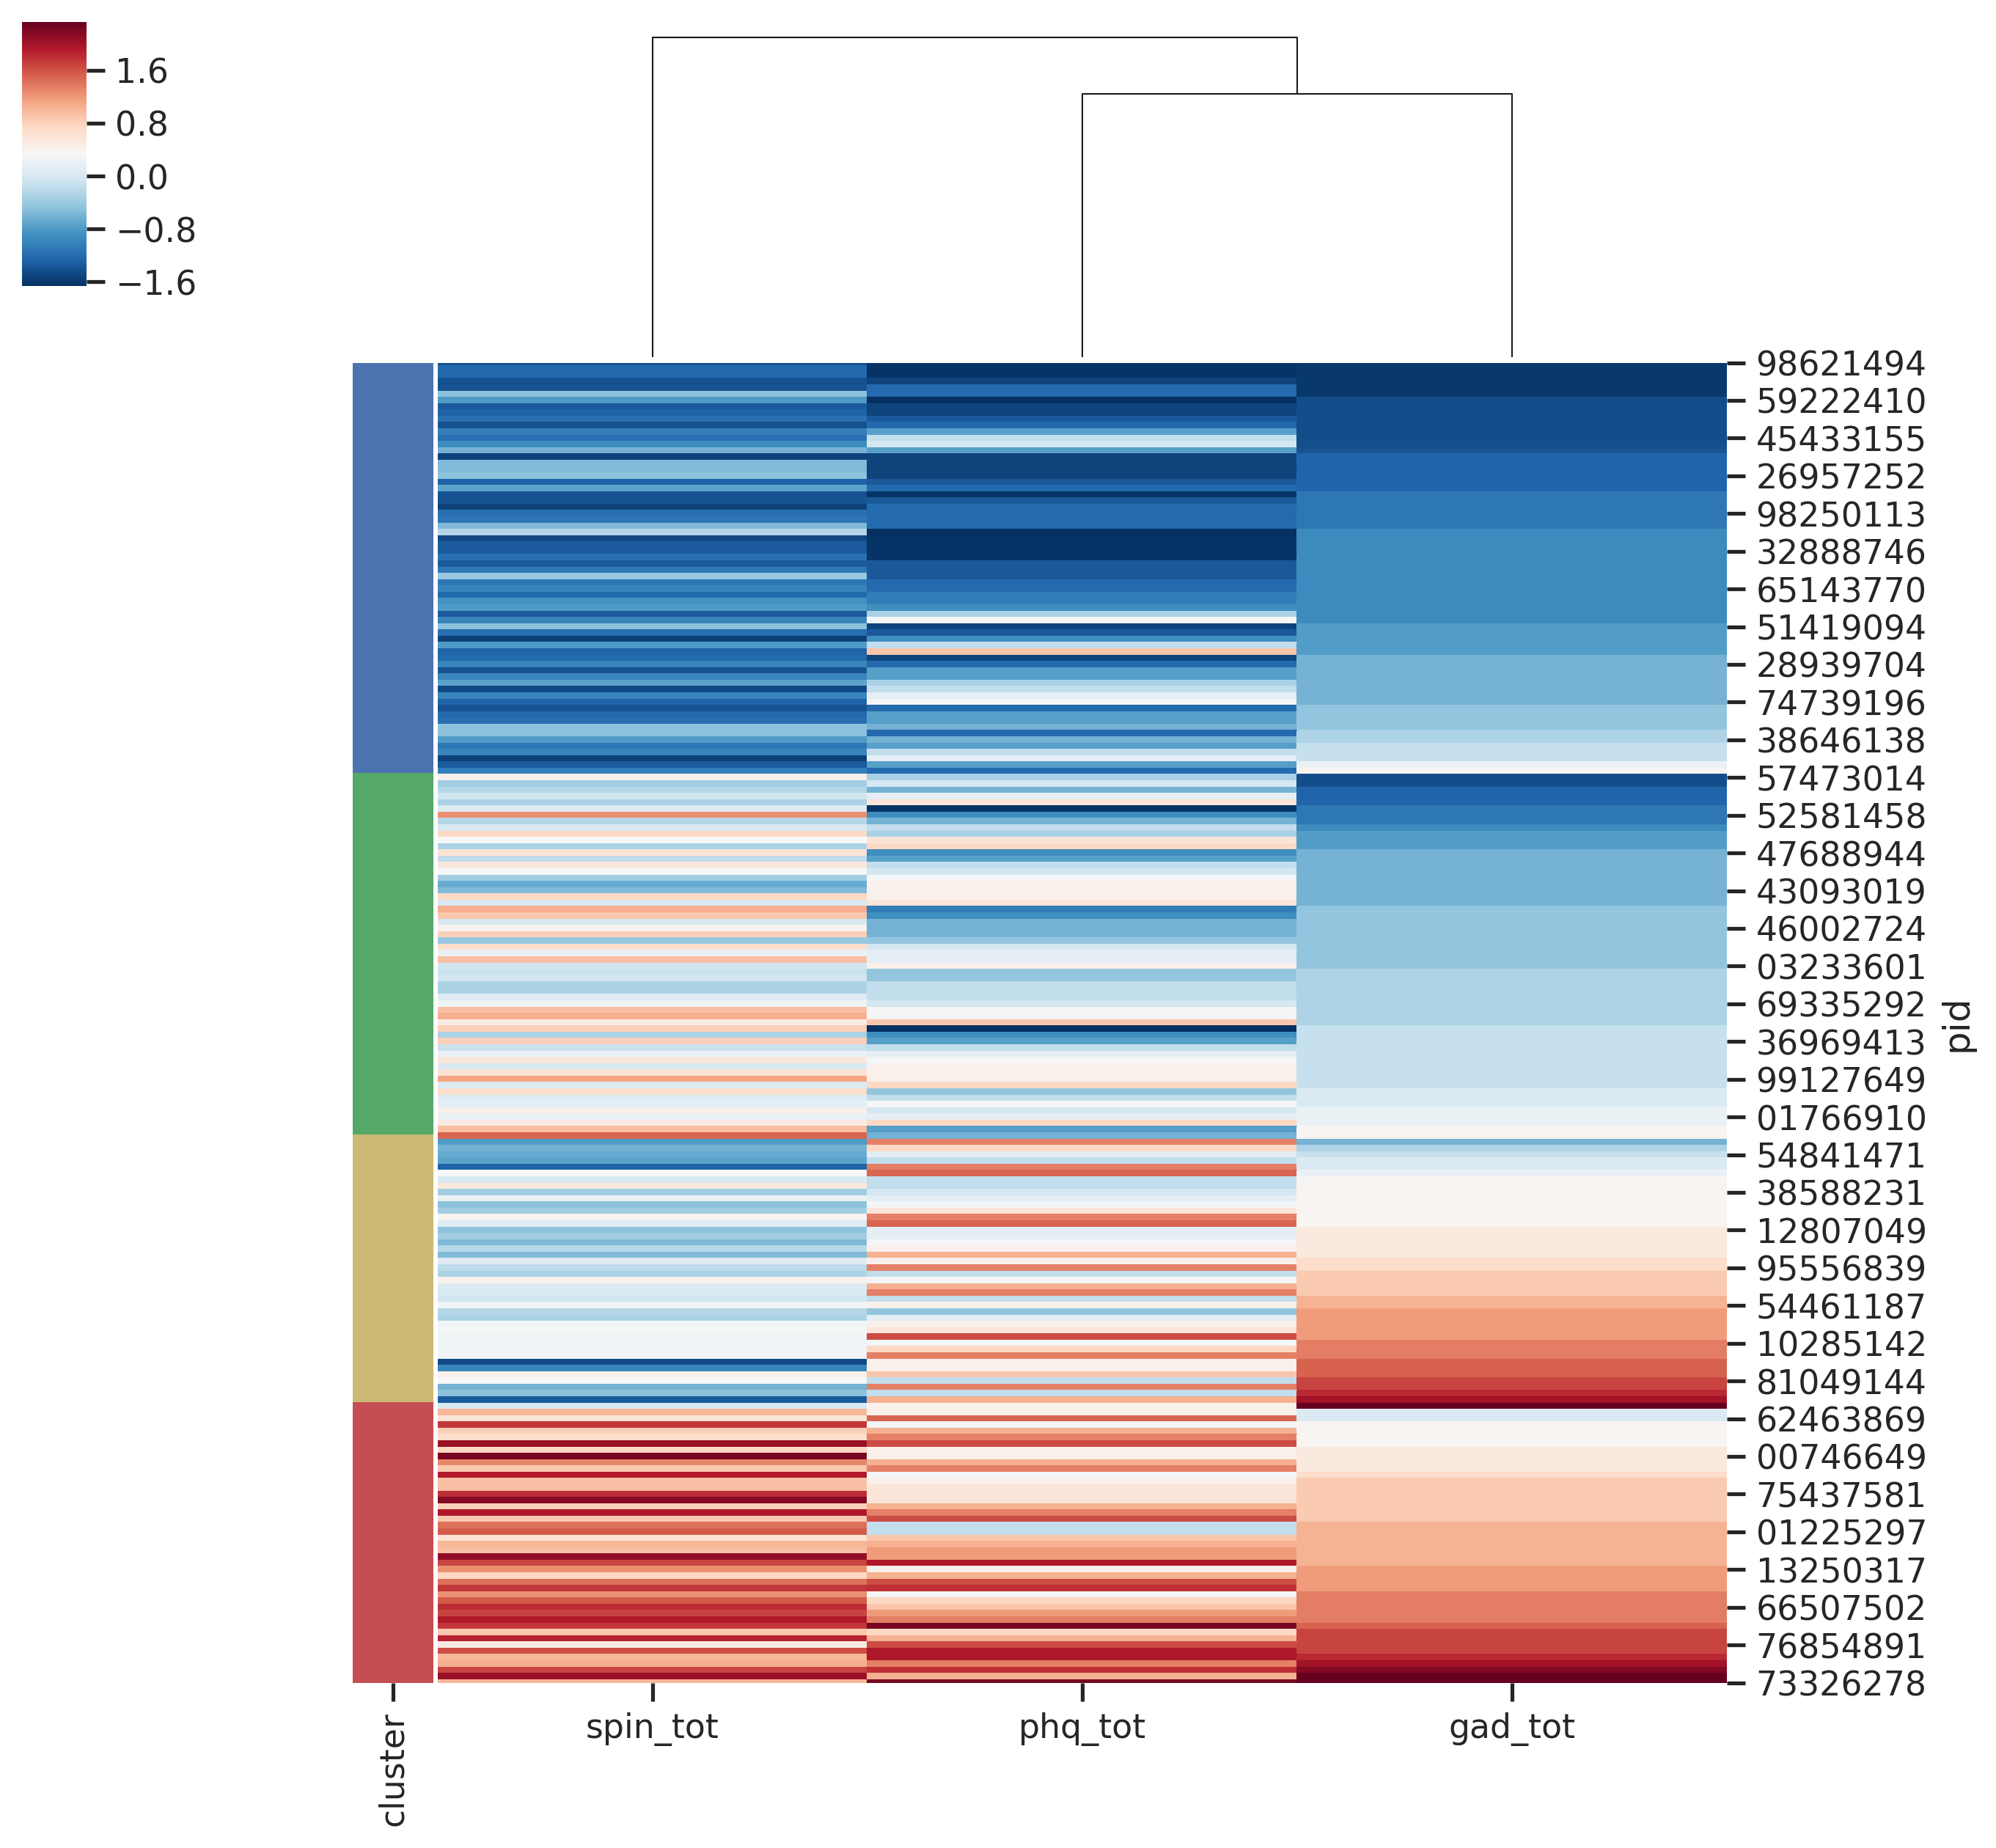

In [342]:
cluster_df = cluster_df.sort_values(by=['cluster', 'gad_tot', 'phq_tot', 'spin_tot'])

clustergrid = sns.clustermap(cluster_df[['spin_tot', 'phq_tot', 'gad_tot']], 
               row_colors=row_colors, 
               row_cluster=False,
               z_score=1,
               cmap='RdBu_r')

# Notes

- sanity check: whether or not visits to a medical professional corresponds with a change in self reported medical visits
- look at location activity across different temporal strides
- how to handle categorical/binary data in clustering?

## Implementation Plan

- ~~pull semantic location from cluster labels from current and previous weeks, but not future weeks~~
    - do we want to do previous weeks?
- ~~TODO port to lifesense utils file~~
- ~~use same clustering algorithm as previously implemented in lifesense_analysis.ipynb notebook~~
- perform feature aggregation for semantic location
- perform basic k-means clustering a la Ros Picard's paper
- then run same t+1 analysis, with a held-out set
- validate circadian rhythm 
- control for age, depression